In [3]:
import os
import glob
import torch
import pandas as pd
import numpy as np
from pathlib import Path

# add code directory to path
import sys
sys.path.append('/cluster/home/kheuto01/code/prob_diff_topk')

from torch_models import NegativeBinomialRegressionModel
from metrics import top_k_onehot_indicator
from functools import partial
from torch_models import NegativeBinomialRegressionModel
from metrics import top_k_onehot_indicator
from torch_perturb.perturbations import perturbed
from torch_models import torch_bpr_uncurried, deterministic_bpr
from matplotlib import pyplot as plt


In [4]:

def load_data(data_dir):
    """Load and process training, validation, and test data."""
    # Load data
    train_X_df = pd.read_csv(os.path.join(data_dir, 'train_x.csv'), index_col=[0,1])
    train_Y_df = pd.read_csv(os.path.join(data_dir, 'train_y.csv'), index_col=[0,1])
    val_X_df = pd.read_csv(os.path.join(data_dir, 'valid_x.csv'), index_col=[0,1])
    val_Y_df = pd.read_csv(os.path.join(data_dir, 'valid_y.csv'), index_col=[0,1])
    test_X_df = pd.read_csv(os.path.join(data_dir, 'test_x.csv'), index_col=[0,1])
    test_Y_df = pd.read_csv(os.path.join(data_dir, 'test_y.csv'), index_col=[0,1])
    
    def convert_df_to_3d_array(df):
        geoids = sorted(df.index.get_level_values('geoid').unique())
        timesteps = sorted(df.index.get_level_values('timestep').unique())
        geoid_to_idx = {geoid: idx for idx, geoid in enumerate(geoids)}
        
        num_timesteps = len(timesteps)
        num_locations = len(geoids)
        num_features = len(df.columns)
        X = np.zeros((num_timesteps, num_locations, num_features))
        
        for (geoid, timestep), row in df.iterrows():
            t_idx = timesteps.index(timestep)
            g_idx = geoid_to_idx[geoid]
            X[t_idx, g_idx, :] = row.values
            
        return X, geoids, timesteps

    def convert_y_df_to_2d_array(y_df, geoids, timesteps):
        num_timesteps = len(timesteps)
        num_locations = len(geoids)
        y = np.zeros((num_timesteps, num_locations))
        geoid_to_idx = {geoid: idx for idx, geoid in enumerate(geoids)}
        
        for (geoid, timestep), value in y_df.iloc[:, 0].items():
            t_idx = timesteps.index(timestep)
            g_idx = geoid_to_idx[geoid]
            y[t_idx, g_idx] = value
            
        return y

    # Process training data
    train_X, geoids, timesteps = convert_df_to_3d_array(train_X_df)#.drop(columns='timestep.1'))
    train_time = np.array([timesteps] * len(geoids)).T
    train_y = convert_y_df_to_2d_array(train_Y_df, geoids, timesteps)

    # Process validation data
    val_X, val_geoids, val_timesteps = convert_df_to_3d_array(val_X_df)#.drop(columns='timestep.1'))
    val_time = np.array([val_timesteps] * len(val_geoids)).T
    val_y = convert_y_df_to_2d_array(val_Y_df, val_geoids, val_timesteps)

    # Process test data
    test_X, test_geoids, test_timesteps = convert_df_to_3d_array(test_X_df)#.drop(columns='timestep.1'))
    test_time = np.array([test_timesteps] * len(test_geoids)).T
    test_y = convert_y_df_to_2d_array(test_Y_df, test_geoids, test_timesteps)

    return {
        'train': (torch.tensor(train_X, dtype=torch.float32), 
                 torch.tensor(train_time, dtype=torch.float32),
                 torch.tensor(train_y, dtype=torch.float32)),
        'val': (torch.tensor(val_X, dtype=torch.float32),
               torch.tensor(val_time, dtype=torch.float32),
               torch.tensor(val_y, dtype=torch.float32)),
        'test': (torch.tensor(test_X, dtype=torch.float32),
                torch.tensor(test_time, dtype=torch.float32),
                torch.tensor(test_y, dtype=torch.float32))
    }

In [5]:
data_dir = '/cluster/tufts/hugheslab/datasets/NSF_OD/cleaned/long/MA'
base_dir = '/cluster/tufts/hugheslab/kheuto01/opioid_hpc_test_long_big/MA/'

In [6]:
model_path = '/cluster/tufts/hugheslab/kheuto01/opioid_hpc_test_long_big/MA/K100_bw30_nw1_ss0.001_nss100_nps100_seed123_sig0.1_tr1/best_model.pth'

In [7]:
device = 'cuda'
K=100

In [8]:
data = load_data(data_dir)

# Move data to device
val_data = tuple(x.to(device) for x in data['val'])
test_data = tuple(x.to(device) for x in data['test'])

In [9]:
model = NegativeBinomialRegressionModel(
    num_locations=data['train'][0].shape[1],
    num_fixed_effects=data['train'][0].shape[2]
).to(device)


# Load saved weights
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

NegativeBinomialRegressionModel()

In [10]:
dist = model(val_data[0], val_data[1])

unconstrained theta: Parameter containing:
tensor([-1.5398], device='cuda:0', requires_grad=True)
Theta: tensor([0.1766], device='cuda:0', grad_fn=<SigmoidBackward0>)


In [11]:
num_score_samples = 1000000

In [51]:
y_sample_TMS = dist.sample((num_score_samples,)).permute(1, 0, 2)
ratio_rating_TMS = y_sample_TMS/y_sample_TMS.sum(dim=-1, keepdim=True)
ratio_rating_TS = ratio_rating_TMS.mean(dim=1)

# Calculate deterministic BPR
det_bpr = deterministic_bpr(ratio_rating_TS, val_data[2], K=K)
det_bpr = torch.mean(det_bpr)
print(f'Det BP: {det_bpr.item()}')

torch.Size([1])
Det BP: 0.6191489100456238


In [31]:
# Repeat the above cell 1000 times
# at each iteration, record the indicies of the top K entries in ratio_rating_TS
# count how many times each location is in the top K entries

num_iters = 1000
top_k_counts = torch.zeros_like(val_data[2])
for i in range(num_iters):
    y_sample_TMS = dist.sample((num_score_samples,)).permute(1, 0, 2)
    ratio_rating_TMS = y_sample_TMS/y_sample_TMS.sum(dim=-1, keepdim=True)
    ratio_rating_TS = ratio_rating_TMS.mean(dim=1)
    top_k_indices = top_k_onehot_indicator(ratio_rating_TS, K)
    top_k_counts += top_k_indices.sum(dim=1)

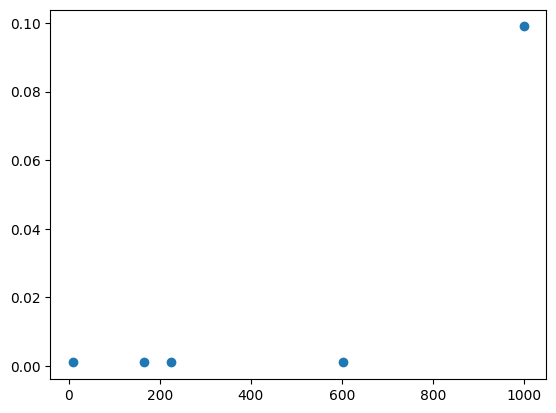

In [48]:
# graph the unique values of the counts and their relative frequency
# dont plot 0's
unique, counts = top_k_counts.unique(return_counts=True)
# set to cpu
unique = unique.cpu().numpy()
counts = counts.cpu().numpy()
unique = unique[1:]
counts = counts[1:]
plt.scatter(unique, counts/num_iters)

In [49]:
counts

array([ 1,  1,  1,  1, 99])

In [53]:
# count distinct values in ratio_rating_TS
unique, counts = torch.unique(ratio_rating_TS, return_counts=True)

In [50]:
unique

array([   9.,  165.,  224.,  602., 1000.], dtype=float32)

In [55]:
y_sample_TMS.sum(dim=-1, keepdim=True).min()

tensor(1979., device='cuda:0')